# Has Alpha

In strategy 9, triples of coins that become sufficiently uncorrelated are just removed from the portfolio, even if there was an open position with them, potentially resulting in a large net loss by not waiting for the triple to revert to its mean.

In [ ]:
# Historical snapshot of coins from December 01, 2019: https://coinmarketcap.com/historical/20191201/ used to
# get a representative set of coins from before the period of analysis to avoid look-ahead bias.

strat_univ = [
    'BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'BCHUSDT', 'LTCUSDT', 'EOSUSDT', 'BNBUSDT',
    'XLMUSDT', 'TRXUSDT', 'ADAUSDT', 'XTZUSDT', 'LINKUSDT', 'ATOMUSDT',
    'NEOUSDT', 'MKRUSDT', 'DASHUSDT', 'ETCUSDT', 'USDCUSDT', 'ONTUSDT', 'VETUSDT',
    'DOGEUSDT', 'BATUSDT', 'ZECUSDT',
    'SNXUSDT', 'QTUMUSDT', 'TUSDUSDT', 'ZRXUSDT',
    'THXUSDT', 'THRUSDT', 'ALGOUSDT', 'REPUSDT', 'NANOUSDT', 'KBCUSDT', 'BTGUSDT', 'RVNUSDT', 'OMGUSDT',
    'CNXUSDT', 'ABBCUSDT', 'XINUSDT', 'VSYSUSDT', 'SEELEUSDT', 'EONUSDT', 'ZBUSDT', 'EKTUSDT', 'DGBUSDT',
    'BTMUSDT', 'LSKUSDT', 'KMDUSDT', 'SAIUSDT', 'LUNAUSDT', 'KCSUSDT', 'FTTUSDT', 'QNTUSDT', 'SXPUSDT',
    'BDXUSDT', 'GAPUSDT', 'BCDUSDT', 'THETAUSDT', 'ICXUSDT', 'FSTUSDT', 'MATICUSDT', 'SCUSDT', 'EVRUSDT',
    'BTTUSDT', 'MOFUSDT', 'IOSTUSDT', 'MCOUSDT', 'WAVESUSDT', 'XVGUSDT', 'MONAUSDT', 'BTSUSDT', 'BCNUSDT',
    'HCUSDT', 'MAIDUSDT', 'NEXOUSDT', 'ARDRUSDT', 'DXUSDT', 'OKBUSDT', 'FXCUSDT', 'RLCUSDT', 'MBUSDT',
    'BXKUSDT', 'AEUSDT', 'ENJUSDT', 'STEEMUSDT', 'SLVUSDT', 'BRZEUSDT', 'ZILUSDT', 'VESTUSDT', 'ZENUSDT',
    'SOLVEUSDT', 'CHZUSDT', 'NOAHUSDT', 'LAUSDT', 'BTMXUSDT', 'ETNUSDT', 'ENGUSDT', 'ILCUSDT', 'NPXSUSDT',
    'CRPTUSDT', 'GNTUSDT', 'SNTUSDT', 'ELFUSDT', 'JWLUSDT', 'FETUSDT', 'BOTXUSDT', 'NRGUSDT', 'DGDUSDT',
    'EXMRUSDT', 'EURSUSDT', 'AOAUSDT', 'RIFUSDT', 'CIX100USDT', 'BFUSDT', 'XZCUSDT', 'FABUSDT', 'GRINUSDT',
    'NETUSDT', 'VERIUSDT', 'DGTXUSDT', 'KNCUSDT', 'RENUSDT', 'STRATUSDT', 'ETPUSDT', 'NEXUSDT', 'NEWUSDT',
    'BCZEROUSDT', 'GXCUSDT', 'TNTUSDT', 'BTC2USDT', 'PPTUSDT', 'USDKUSDT', 'ELAUSDT', 'IGNISUSDT', 'PLCUSDT',
    'BNKUSDT', 'DTRUSDT', 'RCNUSDT', 'HPTUSDT', 'LAMBUSDT', 'MANAUSDT', 'EDCUSDT', 'BEAMUSDT', 'TTUSDT',
    'AIONUSDT', 'BZUSDT', 'WTCUSDT', 'WICCUSDT', 'LRCUSDT', 'BRDUSDT', 'FCTUSDT', 'NULSUSDT', 'FTMUSDT',
    'IOTXUSDT', 'QBITUSDT', 'XMXUSDT', 'YOUUSDT', 'NASUSDT', 'WAXPUSDT', 'ARKUSDT', 'RDDUSDT', 'GNYUSDT',
    'AGVCUSDT', 'HYNUSDT', 'CVCUSDT', 'WANUSDT', 'WINUSDT', 'LINAUSDT', 'RUSDT', 'PAIUSDT', 'FSNUSDT',
    'FUNUSDT', 'DPTUSDT', 'BHDUSDT', 'LOOMUSDT', 'XACUSDT', 'BUSDUSDT', 'BHPUSDT', 'TRUEUSDT', 'LOKIUSDT',
    'QASHUSDT', 'BNTUSDT', 'DOTUSDT', 'SOLUSDT']

## Load And Structure Data

In [ ]:
from binance.client import Client as bnb_client
from binance.client import BinanceAPIException
from datetime import datetime
import pandas as pd

client = bnb_client(tld='US')

def get_price_data_for_coin(coin, freq, start_date):
    bn_data = client.get_historical_klines(coin, freq, start_date)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
        'num_trades','taker_base_volume','taker_quote_volume','ignore']

    bn_data = pd.DataFrame(bn_data, columns=columns)
    bn_data['open_time'] = bn_data['open_time'].map(lambda x: datetime.utcfromtimestamp(x / 1000))
    bn_data['close_time'] = bn_data['close_time'].map(lambda x: datetime.utcfromtimestamp(x / 1000))
    return bn_data


def get_price_data_for_universe(freq, start_date):
    px_data = {}

    for coin in strat_univ:
        try:
            px_data[coin] = get_price_data_for_coin(coin, freq, start_date).set_index('open_time')
            print(f"Downloaded data for {coin}.")
        except BinanceAPIException:
            print(f"Couldn't load data for {coin}.")
    
    return px_data

In [ ]:
data_freq = '4h'
look_back_window_size = 30 * 6
look_back_min_periods = 10 * 6
start_datetime = '2020-01-01 00:00:00'
# in_sample_end = pd.to_datetime("2022-12-31 20:00:00")
# out_sample_start = pd.to_datetime("2023-01-01 00:00:00")

In [ ]:
px_data = get_price_data_for_universe(data_freq, start_datetime)

In [ ]:
px_close = {coin: px_data[coin]["close"] for coin in px_data}
px_close = pd.DataFrame(px_close).astype(float)
px_close.index.rename("datetime", inplace=True)

px_close

In [ ]:
import statsmodels.api as sm
import copy
import numpy as np

z_score_threshold = 2.0
min_data_points_to_transact = 10 * 6
use_min_corr = False
correlation_acceptance_threshold = 0.90
correlation_rejection_threshold = 0.80
# look_back_window_size = 30 * 6
# look_back_min_periods = 10 * 6

def has_high_corr_pair_available(coin, corr_matrix, coins_in_a_triple, px_close_data,
                                 correlation_acceptance_threshold):
    if np.isnan(px_close_data[coin]).any():
        return False
    num_available_coins = 0
    for other_coin in corr_matrix[coin][corr_matrix[coin] > correlation_acceptance_threshold].index:
        if (other_coin != coin and (other_coin not in coins_in_a_triple) and \
            (not np.isnan(px_close_data[other_coin]).any())):
            num_available_coins += 1
    return num_available_coins >= 2


def update_correlated_coins_to_min_corr(coin, corr_matrix, coins_in_a_triple, current_correlated_triples,
                                        px_close_data, correlation_acceptance_threshold):
    min_corr = 1.0
    min_corr_coin = None
    second_smallest_corr = 1.0
    second_min_corr_coin = None
    for other_coin in corr_matrix[coin][corr_matrix[coin] > correlation_acceptance_threshold].index:
        if np.isnan(px_close_data[other_coin]).any():
            continue
        elif other_coin in coins_in_a_triple:
            continue
        elif other_coin != coin and corr_matrix.loc[coin, other_coin] <= min_corr:
            second_smallest_corr, min_corr = min_corr, corr_matrix.loc[coin, other_coin]
            second_min_corr_coin, min_corr_coin = min_corr_coin, other_coin
        elif other_coin != coin and corr_matrix.loc[coin, other_coin] <= second_smallest_corr:
            second_smallest_corr = corr_matrix.loc[coin, other_coin]
            second_min_corr_coin = other_coin
    coins_in_a_triple.add(coin)
    coins_in_a_triple.add(min_corr_coin)
    coins_in_a_triple.add(second_min_corr_coin)
    current_correlated_triples[coin] = pd.DataFrame(0.0, columns=[min_corr_coin, second_min_corr_coin,
                                                                  'alpha', 'residual'],
                                                    index=[])

def update_correlated_coins_to_max_corr(coin, corr_matrix, coins_in_a_triple, current_correlated_triples,
                                        px_close_data, correlation_acceptance_threshold):
    max_corr = -1.0
    max_corr_coin = None
    second_largest_corr = 1.0
    second_largest_corr_coin = None
    for other_coin in corr_matrix[coin][corr_matrix[coin] > correlation_acceptance_threshold].index:
        if np.isnan(px_close_data[other_coin]).any():
            continue
        elif other_coin in coins_in_a_triple:
            continue
        elif other_coin != coin and corr_matrix.loc[coin, other_coin] >= max_corr:
            second_largest_corr, max_corr = max_corr, corr_matrix.loc[coin, other_coin]
            second_largest_corr_coin, max_corr_coin = max_corr_coin, other_coin
        elif other_coin != coin and corr_matrix.loc[coin, other_coin] >= second_largest_corr:
            second_largest_corr = corr_matrix.loc[coin, other_coin]
            second_largest_corr_coin = other_coin
    coins_in_a_triple.add(coin)
    coins_in_a_triple.add(max_corr_coin)
    coins_in_a_triple.add(second_largest_corr_coin)
    current_correlated_triples[coin] = pd.DataFrame(0.0, columns=[max_corr_coin, second_largest_corr_coin,
                                                                  'alpha', 'residual'],
                                                    index=[])


def get_holdings_df(px_close, look_back_min_periods, look_back_window_size, correlation_acceptance_threshold,
                    correlation_rejection_threshold, min_data_points_to_transact, z_score_threshold,
                    use_min_corr):
    holdings_df = pd.DataFrame(0.0, columns=px_close.columns, index=px_close.index)

    current_correlated_triples = dict()
    coins_in_a_triple = set()

    for index in range(look_back_min_periods, len(holdings_df)):
        px_close_window = px_close[max(index-look_back_window_size, 0):index]

        time_index = px_close.index[index]
        holdings_df.loc[time_index] = pd.Series(0.0, index=holdings_df.columns)

        corr_matrix = px_close_window.corr()
        newly_uncorrelated_keys = set()
        for key_coin in current_correlated_triples:
            value_coin_1 = current_correlated_triples[key_coin].columns[0]
            value_coin_2 = current_correlated_triples[key_coin].columns[1]

            triple_list = [key_coin, value_coin_1, value_coin_2]

            if px_close_window[triple_list].iloc[-1].isnull().any():
                newly_uncorrelated_keys.add(key_coin)
            elif ((corr_matrix.loc[key_coin, value_coin_1] < correlation_rejection_threshold or \
                corr_matrix.loc[key_coin, value_coin_2] < correlation_rejection_threshold)):
                newly_uncorrelated_keys.add(key_coin)

        for coin in newly_uncorrelated_keys:
            coins_in_a_triple.remove(coin)
            coins_in_a_triple.remove(current_correlated_triples[coin].columns[0])
            coins_in_a_triple.remove(current_correlated_triples[coin].columns[1])

            if coin in current_correlated_triples: # only the dependent coin will appear as a key
                del current_correlated_triples[coin]

        for coin in holdings_df.columns:
            if ((coin not in coins_in_a_triple) and \
                has_high_corr_pair_available(coin, corr_matrix, coins_in_a_triple, px_close_window,
                                             correlation_acceptance_threshold) and \
                use_min_corr):
                update_correlated_coins_to_min_corr(coin, corr_matrix, coins_in_a_triple,
                                                    current_correlated_triples, px_close_window,
                                                    correlation_acceptance_threshold)
            elif ((coin not in coins_in_a_triple) and \
                  has_high_corr_pair_available(coin, corr_matrix, coins_in_a_triple, px_close_window,
                                               correlation_acceptance_threshold) and \
                  (not use_min_corr)):
                update_correlated_coins_to_max_corr(coin, corr_matrix, coins_in_a_triple,
                                                    current_correlated_triples, px_close_window,
                                                    correlation_acceptance_threshold)

        for coin in current_correlated_triples:
            independent_coin_1 = current_correlated_triples[coin].columns[0]
            independent_coin_2 = current_correlated_triples[coin].columns[1]

            model = sm.OLS(px_close_window[coin].iloc[:-1],
                           sm.add_constant(px_close_window[[independent_coin_1, independent_coin_2]].iloc[:-1]))
            result = model.fit()
            result_data = {
                independent_coin_1: result.params[independent_coin_1],
                independent_coin_2: result.params[independent_coin_2],
                'alpha': result.params['const']
            }
            estimate = px_close_window[independent_coin_1].iloc[-1] * result.params[independent_coin_1] + \
                px_close_window[independent_coin_2].iloc[-1] * result.params[independent_coin_2] + \
                result.params['const']
            result_data['residual'] = px_close_window[coin].iloc[-1] - estimate
            result_series = pd.Series(result_data)
            current_correlated_triples[coin].loc[index] = result_series

            if len(current_correlated_triples[coin]) >= min_data_points_to_transact:
                z_score_look_back_len = min(look_back_window_size, len(current_correlated_triples[coin]))
                look_back_coin_regression_data = current_correlated_triples[coin].iloc[(-z_score_look_back_len):]
                residual_mean = look_back_coin_regression_data['residual'].mean()
                residual_std = look_back_coin_regression_data['residual'].std()
                z_score = (result_data['residual'] - residual_mean) / residual_std

                if z_score >= z_score_threshold:
                    holdings_df.loc[time_index, coin] = -1.0
                    holdings_df.loc[time_index, independent_coin_1] = result_data[independent_coin_1]
                    holdings_df.loc[time_index, independent_coin_2] = result_data[independent_coin_2]
                elif z_score <= -z_score_threshold:
                    holdings_df.loc[time_index, coin] = 1.0
                    holdings_df.loc[time_index, independent_coin_1] = -result_data[independent_coin_1]
                    holdings_df.loc[time_index, independent_coin_2] = -result_data[independent_coin_2]
        holdings_df.loc[time_index] = holdings_df.loc[time_index] / holdings_df.loc[time_index].abs().sum()
        
    return holdings_df

In [ ]:
def get_net_return(strat_holdings, ret):
    # assume that strat_holdings have already been shifted back in time to avoid look-ahead bias.
    gross_ret = (strat_holdings * ret).sum(axis=1)
    
    turnover = (strat_holdings.fillna(0) - strat_holdings.shift().fillna(0)).abs().sum(axis=1)
    tcost_bps = 20
    return gross_ret.subtract(turnover * tcost_bps * 1e-4, fill_value=0)

In [ ]:
import matplotlib.pyplot as plt

def get_net_returns(px_close, holdings_df, plot_title):
    market_returns = px_close / px_close.shift() - 1

    net_returns_ser = get_net_return(holdings_df, market_returns)
    fig = plt.subplots(figsize=(16, 5))
    plt.title(plot_title)
    plt.plot(net_returns_ser.cumsum())
    
    return net_returns_ser

In [ ]:
def get_sharpe_ratio_data(net_returns_se):
    sr_data = dict()
    sr_data["total sr"] = net_returns_se.mean() / net_returns_se.std() * np.sqrt(365 * 6)

    out_sample_start = pd.to_datetime("2023-01-01 00:00:00")
    in_sample_end = out_sample_start - pd.Timedelta(hours=4)

    sr_data["in-sample sr"] = net_returns_se.loc[:in_sample_end].mean() / net_returns_se.loc[:in_sample_end].std() * np.sqrt(365 * 6)
    sr_data["out-sample sr"] = net_returns_se.loc[out_sample_start:].mean() / net_returns_se.loc[out_sample_start:].std() * np.sqrt(365 * 6)
    sr_series = pd.Series(sr_data)
    return sr_series

In [ ]:
# outcome_df = pd.read_csv("./strat_09a_results.csv", index_col=["z-score", "corr thresholds", "corr priority"])

# outcome_data = dict()
# for triple_index in outcome_df.index:
#     updated_index = (triple_index[0], tuple(map(float, triple_index[1][1:-1].split(','))), triple_index[2])
#     outcome_data[updated_index] = outcome_df.loc[triple_index]

# outcome_data

Note: The time and output from running the following cell for all combinations of parameters that I was interested in trying was excessively large so I ran the cell with each combination sequentially and wrote the output to a csv file to store.

In [ ]:
index_selections = []

for z_score_threshold in (1.0, 1.5, 2.0, 2.5, 3.0):
    for correlation_threshold_pair in ((0.9, 0.8), (0.95, 0.90)):
        for use_min_corr in (False, True):
            index_selections.append((z_score_threshold, correlation_threshold_pair, use_min_corr))
index_selections

In [ ]:
len(index_selections)

##################################################################################

In [189]:
index_selection_index = 19

In [ ]:
z_score_threshold = index_selections[index_selection_index][0]
correlation_acceptance_threshold, correlation_rejection_threshold = index_selections[index_selection_index][1]
use_min_corr = index_selections[index_selection_index][2]

min_data_points_to_transact = 10 * 6

holdings_df = get_holdings_df(px_close, look_back_min_periods, look_back_window_size,
                              correlation_acceptance_threshold, correlation_rejection_threshold,
                              min_data_points_to_transact, z_score_threshold, use_min_corr)
plot_title = f"Cumulative Returns: z_score_threshold = {z_score_threshold}, correlation_thresholds = {(correlation_acceptance_threshold, correlation_rejection_threshold)}, {'MIN CORR' if use_min_corr else 'MAX CORR'}"
net_returns_ser = get_net_returns(px_close, holdings_df, plot_title)
sharpe_ratio_ser = get_sharpe_ratio_data(net_returns_ser)

<Axes: xlabel='datetime'>

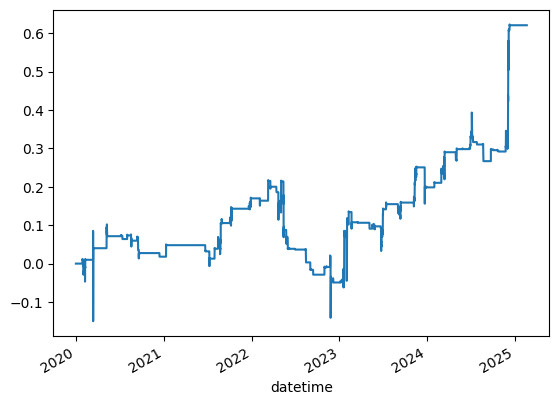

In [193]:
net_returns_ser.cumsum().plot()

In [195]:
sharpe_ratio_ser

total sr         0.560577
in-sample sr    -0.074669
out-sample sr    1.495641
dtype: float64

In [196]:
outcome_df = pd.read_csv("./strat_09a_01_results.csv",
                         index_col=["z-score", "corr thresholds", "corr selection method"])
outcome_df

total sr  in-sample sr  \
z-score corr thresholds corr selection method                           
1.0     (0.9, 0.8)      MAX CORR              -0.650743     -1.622978   
                        MIN CORR              -0.252703     -1.256011   
        (0.95, 0.9)     MAX CORR              -0.206988     -0.680178   
                        MIN CORR              -0.742996     -0.881547   
1.5     (0.9, 0.8)      MAX CORR               0.310208     -0.628968   
                        MIN CORR               0.496694     -0.509479   
        (0.95, 0.9)     MAX CORR              -0.039182     -0.695511   
                        MIN CORR              -0.382873     -0.953951   
2.0     (0.9, 0.8)      MAX CORR               0.533964     -0.468822   
                        MIN CORR               1.030522     -0.745212   
        (0.95, 0.9)     MAX CORR               0.386755     -0.450139   
                        MIN CORR               0.414110     -0.554583   
2.5     (0.9, 0.8)      MAX CORR               0.016052     -0.769404   
                        MIN CORR               0.124080     -1.005412   
        (0.95, 0.9)     MAX CORR              -0.068216     -0.580408   
                        MIN CORR               0.165586     -0.452383   
3.0     (0.9, 0.8)      MAX CORR               0.296636     -0.515956   
                        MIN CORR               0.456817     -0.711059   
        (0.95, 0.9)     MAX CORR               0.128900     -0.526451   

                                               out-sample sr  
z-score corr thresholds corr selection method                 
1.0     (0.9, 0.8)      MAX CORR                    0.841230  
                        MIN CORR                    1.030496  
        (0.95, 0.9)     MAX CORR                    0.442945  
                        MIN CORR                   -0.557519  
1.5     (0.9, 0.8)      MAX CORR                    1.607211  
                        MIN CORR                    1.779660  
        (0.95, 0.9)     MAX CORR                    0.850395  
                        MIN CORR                    0.438652  
2.0     (0.9, 0.8)      MAX CORR                    1.869443  
                        MIN CORR                    3.089597  
        (0.95, 0.9)     MAX CORR                    1.405185  
                        MIN CORR                    1.624823  
2.5     (0.9, 0.8)      MAX CORR                    1.052462  
                        MIN CORR                    1.503361  
        (0.95, 0.9)     MAX CORR                    0.526423  
                        MIN CORR                    0.969992  
3.0     (0.9, 0.8)      MAX CORR                    1.341428  
                        MIN CORR                    1.726392  
        (0.95, 0.9)     MAX CORR                    0.941551

In [197]:
raw_outcome_data = {"total sr": [], "in-sample sr": [], "out-sample sr": []}
indices = []

for (df_index, df_val) in outcome_df.iterrows():
    dict_index = (df_index[0], tuple(map(float, df_index[1][1:-1].split(','))), df_index[2])
    
    indices.append(dict_index)
    raw_outcome_data["total sr"].append(df_val["total sr"])
    raw_outcome_data["in-sample sr"].append(df_val["in-sample sr"])
    raw_outcome_data["out-sample sr"].append(df_val["out-sample sr"])

raw_outcome_data

{'total sr': [-0.6507426991672144,
  -0.2527025408267335,
  -0.2069879623967908,
  -0.7429957654634999,
  0.3102077752955775,
  0.4966941251210693,
  -0.0391824775229972,
  -0.3828726367767001,
  0.5339639522746832,
  1.030522485081283,
  0.3867553480392607,
  0.414109557690187,
  0.0160517458956371,
  0.1240799690125391,
  -0.0682164007662708,
  0.165585740533335,
  0.2966362494080564,
  0.456817035405614,
  0.1289001988355122],
 'in-sample sr': [-1.6229778432776298,
  -1.256010930552529,
  -0.6801779684326995,
  -0.8815472159780622,
  -0.628967870879385,
  -0.5094789219832413,
  -0.6955108306125317,
  -0.9539506093089186,
  -0.4688222568796411,
  -0.7452115436444683,
  -0.4501394765391736,
  -0.5545833868180166,
  -0.7694044839101751,
  -1.005411905532261,
  -0.5804081352743427,
  -0.4523825186714413,
  -0.5159557047161004,
  -0.7110592241934439,
  -0.5264509486453148],
 'out-sample sr': [0.841229998195887,
  1.0304961438357902,
  0.4429452626398012,
  -0.5575189982221558,
  1.607210

In [198]:
tuple_index = (index_selections[index_selection_index][0],
               index_selections[index_selection_index][1],
               "MIN CORR" if index_selections[index_selection_index][2] else "MAX CORR")

raw_outcome_data["total sr"].append(sharpe_ratio_ser["total sr"])
raw_outcome_data["in-sample sr"].append(sharpe_ratio_ser["in-sample sr"])
raw_outcome_data["out-sample sr"].append(sharpe_ratio_ser["out-sample sr"])
indices.append(tuple_index)

outcome_df = pd.DataFrame(
    raw_outcome_data,
    index=pd.MultiIndex.from_tuples(indices, names=["z-score", "corr thresholds", "corr selection method"])
)

outcome_df

total sr  in-sample sr  \
z-score corr thresholds corr selection method                           
1.0     (0.9, 0.8)      MAX CORR              -0.650743     -1.622978   
                        MIN CORR              -0.252703     -1.256011   
        (0.95, 0.9)     MAX CORR              -0.206988     -0.680178   
                        MIN CORR              -0.742996     -0.881547   
1.5     (0.9, 0.8)      MAX CORR               0.310208     -0.628968   
                        MIN CORR               0.496694     -0.509479   
        (0.95, 0.9)     MAX CORR              -0.039182     -0.695511   
                        MIN CORR              -0.382873     -0.953951   
2.0     (0.9, 0.8)      MAX CORR               0.533964     -0.468822   
                        MIN CORR               1.030522     -0.745212   
        (0.95, 0.9)     MAX CORR               0.386755     -0.450139   
                        MIN CORR               0.414110     -0.554583   
2.5     (0.9, 0.8)      MAX CORR               0.016052     -0.769404   
                        MIN CORR               0.124080     -1.005412   
        (0.95, 0.9)     MAX CORR              -0.068216     -0.580408   
                        MIN CORR               0.165586     -0.452383   
3.0     (0.9, 0.8)      MAX CORR               0.296636     -0.515956   
                        MIN CORR               0.456817     -0.711059   
        (0.95, 0.9)     MAX CORR               0.128900     -0.526451   
                        MIN CORR               0.560577     -0.074669   

                                               out-sample sr  
z-score corr thresholds corr selection method                 
1.0     (0.9, 0.8)      MAX CORR                    0.841230  
                        MIN CORR                    1.030496  
        (0.95, 0.9)     MAX CORR                    0.442945  
                        MIN CORR                   -0.557519  
1.5     (0.9, 0.8)      MAX CORR                    1.607211  
                        MIN CORR                    1.779660  
        (0.95, 0.9)     MAX CORR                    0.850395  
                        MIN CORR                    0.438652  
2.0     (0.9, 0.8)      MAX CORR                    1.869443  
                        MIN CORR                    3.089597  
        (0.95, 0.9)     MAX CORR                    1.405185  
                        MIN CORR                    1.624823  
2.5     (0.9, 0.8)      MAX CORR                    1.052462  
                        MIN CORR                    1.503361  
        (0.95, 0.9)     MAX CORR                    0.526423  
                        MIN CORR                    0.969992  
3.0     (0.9, 0.8)      MAX CORR                    1.341428  
                        MIN CORR                    1.726392  
        (0.95, 0.9)     MAX CORR                    0.941551  
                        MIN CORR                    1.495641

In [199]:
outcome_df.to_csv("./strat_09a_01_results.csv")

###################################################################

In [281]:
index_selection_index = 8 # update this before starting on the evening of Feb. 18, 2025

In [ ]:
z_score_threshold = index_selections[index_selection_index][0]
correlation_acceptance_threshold, correlation_rejection_threshold = index_selections[index_selection_index][1]
use_min_corr = index_selections[index_selection_index][2]

min_data_points_to_transact = 5 * 6

holdings_df = get_holdings_df(px_close, look_back_min_periods, look_back_window_size,
                              correlation_acceptance_threshold, correlation_rejection_threshold,
                              min_data_points_to_transact, z_score_threshold, use_min_corr)
plot_title = f"Cumulative Returns: z_score_threshold = {z_score_threshold}, correlation_thresholds = {(correlation_acceptance_threshold, correlation_rejection_threshold)}, {'MIN CORR' if use_min_corr else 'MAX CORR'}"
net_returns_ser = get_net_returns(px_close, holdings_df, plot_title)
sharpe_ratio_ser = get_sharpe_ratio_data(net_returns_ser)

<Axes: xlabel='datetime'>

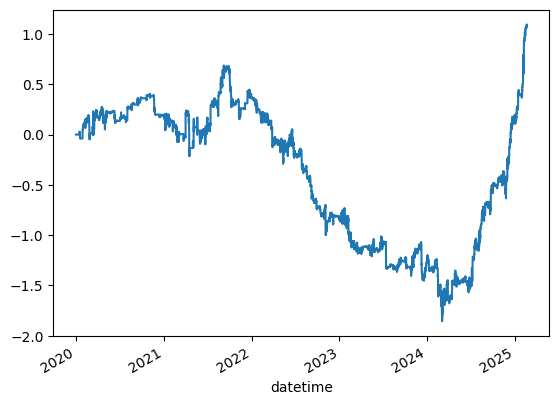

In [283]:
net_returns_ser.cumsum().plot()

In [284]:
sharpe_ratio_ser

total sr         0.317711
in-sample sr    -0.444836
out-sample sr    1.266375
dtype: float64

In [285]:
outcome_df = pd.read_csv("./strat_09a_5d_to_trade_results.csv",
                         index_col=["z-score", "corr thresholds", "corr selection method"])
outcome_df

total sr  in-sample sr  \
z-score corr thresholds corr selection method                           
1.0     (0.9, 0.8)      MAX CORR              -0.371734     -1.297334   
                        MIN CORR               0.114213     -1.018646   
        (0.95, 0.9)     MAX CORR              -0.489222     -1.163892   
                        MIN CORR              -0.737505     -1.419809   
1.5     (0.9, 0.8)      MAX CORR               0.186733     -0.795482   
                        MIN CORR               0.522838     -0.504369   
        (0.95, 0.9)     MAX CORR              -0.141884     -0.970539   
                        MIN CORR              -0.470231     -1.557879   

                                               out-sample sr  
z-score corr thresholds corr selection method                 
1.0     (0.9, 0.8)      MAX CORR                    1.054684  
                        MIN CORR                    1.537183  
        (0.95, 0.9)     MAX CORR                    0.528455  
                        MIN CORR                    0.199728  
1.5     (0.9, 0.8)      MAX CORR                    1.577477  
                        MIN CORR                    1.692897  
        (0.95, 0.9)     MAX CORR                    1.092508  
                        MIN CORR                    1.103760

In [286]:
raw_outcome_data = {"total sr": [], "in-sample sr": [], "out-sample sr": []}
indices = []

for (df_index, df_val) in outcome_df.iterrows():
    dict_index = (df_index[0], tuple(map(float, df_index[1][1:-1].split(','))), df_index[2])
    
    indices.append(dict_index)
    raw_outcome_data["total sr"].append(df_val["total sr"])
    raw_outcome_data["in-sample sr"].append(df_val["in-sample sr"])
    raw_outcome_data["out-sample sr"].append(df_val["out-sample sr"])

raw_outcome_data

{'total sr': [-0.3717338636741059,
  0.1142127766580647,
  -0.4892215342413774,
  -0.7375054438615923,
  0.1867327756008611,
  0.5228384119447201,
  -0.1418844184288331,
  -0.4702312085355486],
 'in-sample sr': [-1.297334256708883,
  -1.018646344693364,
  -1.163891819294558,
  -1.4198089261339333,
  -0.7954823975767665,
  -0.5043685241038286,
  -0.9705392342624884,
  -1.5578793881644937],
 'out-sample sr': [1.0546841976656487,
  1.5371826700310054,
  0.5284545878356762,
  0.1997281373023924,
  1.5774769121663283,
  1.6928971105208044,
  1.0925081240123091,
  1.1037596078092082]}

In [287]:
tuple_index = (index_selections[index_selection_index][0],
               index_selections[index_selection_index][1],
               "MIN CORR" if index_selections[index_selection_index][2] else "MAX CORR")

raw_outcome_data["total sr"].append(sharpe_ratio_ser["total sr"])
raw_outcome_data["in-sample sr"].append(sharpe_ratio_ser["in-sample sr"])
raw_outcome_data["out-sample sr"].append(sharpe_ratio_ser["out-sample sr"])
indices.append(tuple_index)

outcome_df = pd.DataFrame(
    raw_outcome_data,
    index=pd.MultiIndex.from_tuples(indices, names=["z-score", "corr thresholds", "corr selection method"])
)
# outcome_df.index.set_names(["z-score", "corr thresholds", "corr selection method"], inplace=True)
outcome_df

total sr  in-sample sr  \
z-score corr thresholds corr selection method                           
1.0     (0.9, 0.8)      MAX CORR              -0.371734     -1.297334   
                        MIN CORR               0.114213     -1.018646   
        (0.95, 0.9)     MAX CORR              -0.489222     -1.163892   
                        MIN CORR              -0.737505     -1.419809   
1.5     (0.9, 0.8)      MAX CORR               0.186733     -0.795482   
                        MIN CORR               0.522838     -0.504369   
        (0.95, 0.9)     MAX CORR              -0.141884     -0.970539   
                        MIN CORR              -0.470231     -1.557879   
2.0     (0.9, 0.8)      MAX CORR               0.317711     -0.444836   

                                               out-sample sr  
z-score corr thresholds corr selection method                 
1.0     (0.9, 0.8)      MAX CORR                    1.054684  
                        MIN CORR                    1.537183  
        (0.95, 0.9)     MAX CORR                    0.528455  
                        MIN CORR                    0.199728  
1.5     (0.9, 0.8)      MAX CORR                    1.577477  
                        MIN CORR                    1.692897  
        (0.95, 0.9)     MAX CORR                    1.092508  
                        MIN CORR                    1.103760  
2.0     (0.9, 0.8)      MAX CORR                    1.266375

In [288]:
outcome_df.to_csv("./strat_09a_5d_to_trade_results.csv")

###################################################################

In [ ]:
outcome_df = pd.read_csv("./strat_09a_results.csv", index_col=["z-score", "corr thresholds", "corr priority"])
outcome_df

Conclusion: z = 3.0, (0.95, 0.9), min-corr selection --> out sample: 0.513303, in sample: 0.292800